# Google Colab 한글 폰트 설치

In [ ]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


- 테스트

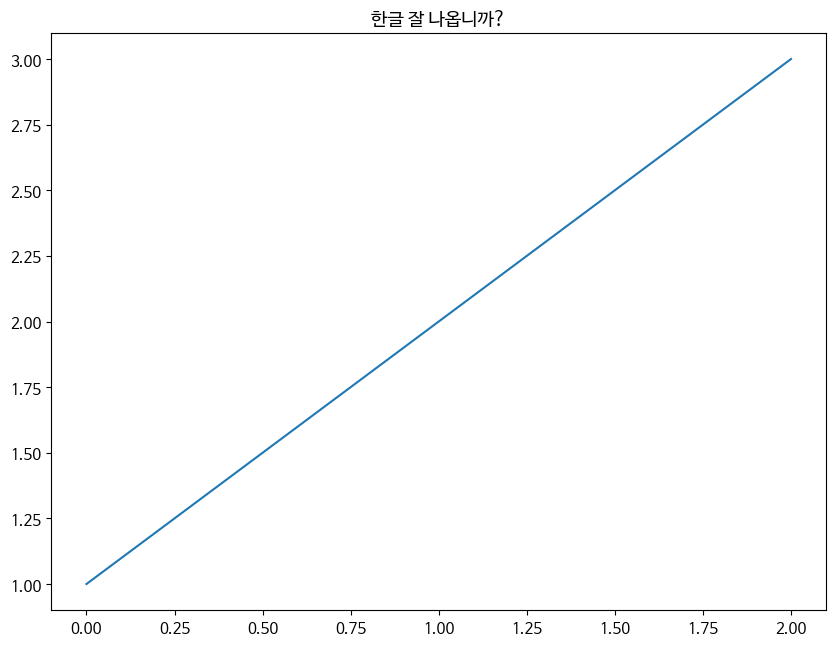

In [ ]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Colab과 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 주요 라이브러리 및 환경설정

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 데이터 불러오기
- UCI 기계학습 Repo에서 사용할 수 있는 원본 데이터 집합의 단축 및 정리된 버전
- 2016년 9월 29일 오후 5시에 시작, 2019년 9울 30일 오후 11시에 끝.

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/metro_interstate_traffic_volume_preprocessed.csv")
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


# 데이터 탐색 수행
- 시간 경과에 따른 교통량의 변화 시각화
- 데이터 집합이 17,000개 이상의 데이터 포함
- 하루의 시작과 끝에서 교통량이 감소
  + 지도 : https://maps.app.goo.gl/hKAqSaN84G8eQS6z6

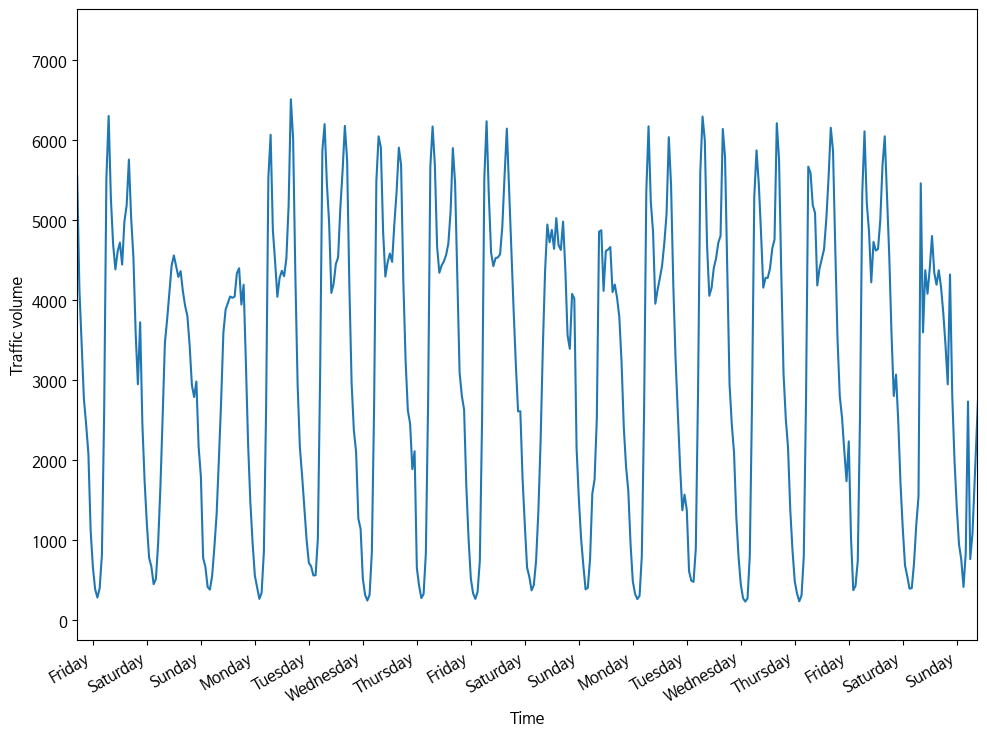

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

- 다중 출력 모델의 대상이 될 시간별 기온 도식화
- 연간 계절성 확인

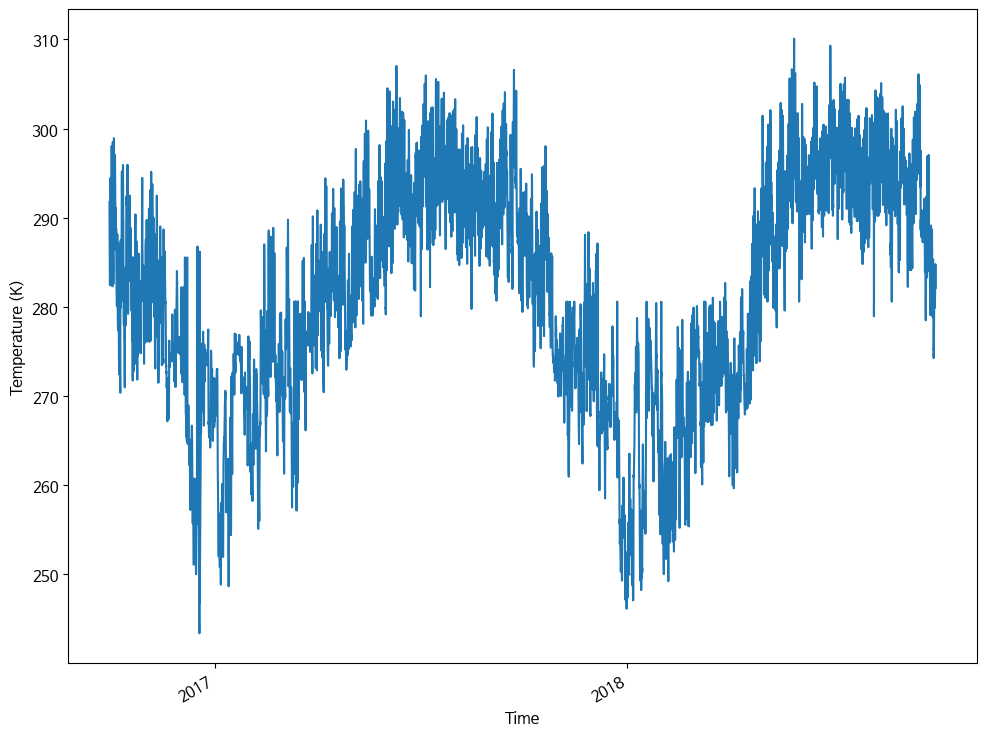

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

- 기온의 일별 계절성 관찰

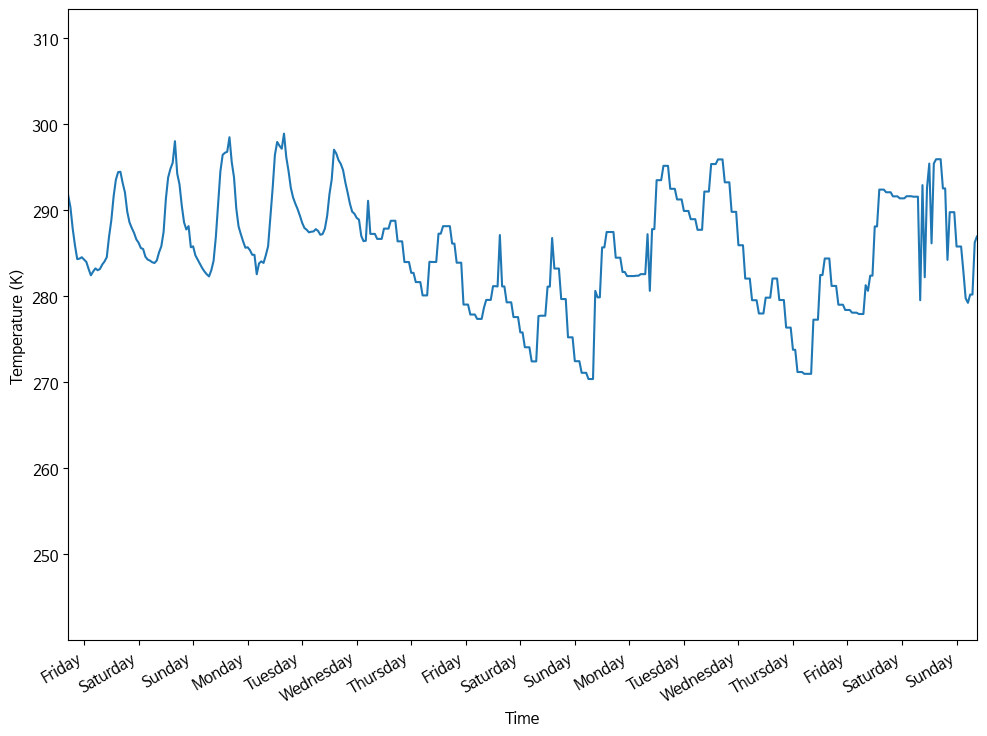

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

# Feature Engineering
- rain_1h는 데이터 집합 대부분이 0, 따라서 변수 제거
- snow_1h 전체가 0, 따라서 변수 제거

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


In [ ]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

df.shape

(17551, 4)

## 날짜 인코딩 변환 (사인, 코사인 변환)
- 날짜를 숫자로 변경처리해야 함
- 간단한 방법 : 날짜를 초 단위로 변경

In [ ]:
timestamp_s = timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)
timestamp_s[:1]

,date_time
0,1.475168e+09


- 날짜를 단순히 초 단위로 표현하면, 시간에 따라 선형적으로 증가하기 때문에, 시간의 주기적 특성을 잃음
- 시간의 주기적 동작을 복구하기 위해 변환 적용 (sin 함수)

In [ ]:
day = 24 * 60 * 60 # 하루의 초 수를 계산함
df['day_sin'] = (np.sin(timestamp_s * (2 * np.pi/day))).values

In [ ]:
df.head()

,date_time,temp,clouds_all,traffic_volume,day_sin
0,2016-09-29 17:00:00,291.75,0,5551.0,-0.965926
1,2016-09-29 18:00:00,290.36,0,4132.0,-1.000000
2,2016-09-29 19:00:00,287.86,0,3435.0,-0.965926
3,2016-09-29 20:00:00,285.91,0,2765.0,-0.866025
4,2016-09-29 21:00:00,284.31,0,2443.0,-0.707107


- 오전과 오후까지 구분하고 싶을 때는 코사인 변환 적용

In [ ]:
# 초 단위인 타임스탬프에 코사인 변환 적용
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
df = df.drop(['date_time'], axis=1)
df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0,5551.0,-0.965926,-2.588190e-01
1,290.36,0,4132.0,-1.000000,-4.048636e-12
2,287.86,0,3435.0,-0.965926,2.588190e-01
3,285.91,0,2765.0,-0.866025,5.000000e-01
4,284.31,0,2443.0,-0.707107,7.071068e-01


- 하루의 주기를 유지하면서 시간을 숫자값으로 인코딩하는데 변환

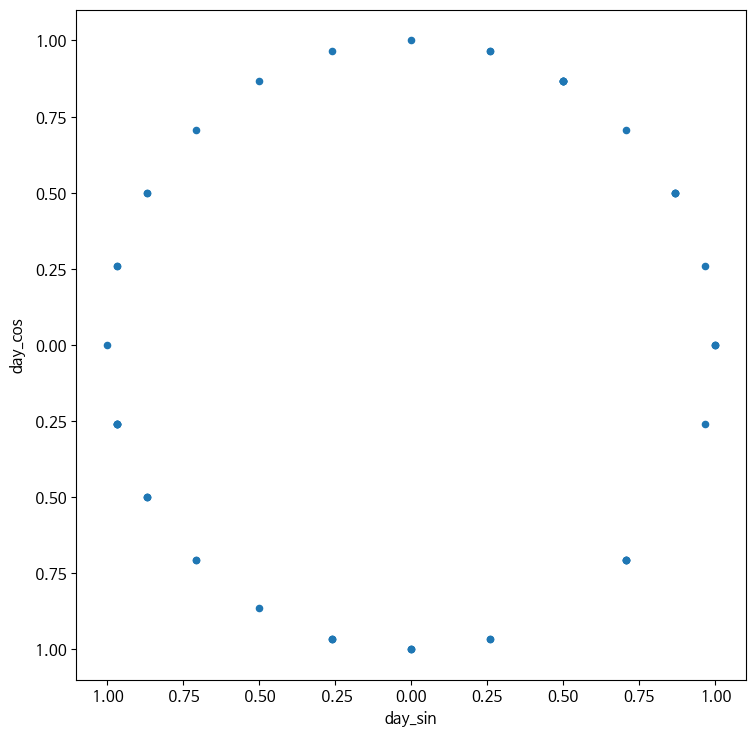

In [ ]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

##  데이터 분리
- 훈련, 검증, 테스트 집합을 간단하게 분할하여 사용
  + 7:2:1 분할

In [ ]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((12285, 5), (3510, 5), (1756, 5))

## 스케일 변환
- 데이터 저장 전 모든 값이 0과 1 사이가 되도록 규모 변환
- 딥러닝 모델을 훈련하는 데 필요한 시간이 줄어들고 성능 향상
- 데이터 누수 방지 위해 scaler 훈련 집합에만 피팅함
  + 훈련 데이터만 있고, 미래에 대한 데이터는 없는 것처럼 시뮬레이션 할 수 있음

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df) # 훈련 집합에만 피팅하는 것에 유의

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

# 데이터 내보내기

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/"

train_df.to_csv(DATA_PATH + 'train.csv')
val_df.to_csv(DATA_PATH + 'val.csv')
test_df.to_csv(DATA_PATH + 'test.csv')